In [1]:
include("../src/ScatterersDDA.jl")
using .ScatterersDDA
using LinearAlgebra
using AbstractAlgebra
using Polynomials
using SpecialFunctions
using Random
using ForwardDiff
using Plots
using Cubature
using ZChop
using NLsolve
using Roots
using LineSearches
using Symbolics
using Combinatorics

### Test cofactors

In [15]:
perms = permsingleinversion(3)
[perms[:,i] for i in axes(perms, 2)]

3-element Vector{Vector{Int64}}:
 [2, 1, 3]
 [3, 2, 1]
 [1, 3, 2]

In [2]:
G1 = 0.1
G2 = 0.1
matrix = [0.8 G1 G2 G1
          G1 1.2 G1 G2
          G2 G1 1.1 G1
          G1 G2 G1 1.5]

4×4 Matrix{Float64}:
 0.8  0.1  0.1  0.1
 0.1  1.2  0.1  0.1
 0.1  0.1  1.1  0.1
 0.1  0.1  0.1  1.5

In [3]:
println(det_weak(matrix))
println(det(matrix))

1.5059 + 0.0im
1.5148000000000004

### Test minor matrices generation

In [29]:
matrix = [1 0 2 2; 0 1 4 4; 3 2 0 8; 2 4 5 1]

4×4 Matrix{Int64}:
 1  0  2  2
 0  1  4  4
 3  2  0  8
 2  4  5  1

In [46]:
nscatt = 4
cindex = 2
sum(det.([matrix[setdiff(1:end, i), setdiff(1:end, i)] for i in combinations([j for j in 1:nscatt], cindex)]))

-71.0

In [27]:
[i for i in 1:4]

4-element Vector{Int64}:
 1
 2
 3
 4

In [19]:
using Combinatorics

In [23]:
collect(combinations([1,2,3], 2))

3-element Vector{Vector{Int64}}:
 [1, 2]
 [1, 3]
 [2, 3]

### Test polynomial coefficients generation

In [7]:
@variables x[1:6]
Polynomials.fromroots([1*x[1], x[2]+x[3]*1im, 3*x[1], x[4], 3*x[5]*1im])

LoadError: TypeError: non-boolean (Num) used in boolean context

In [6]:
@variables x[1:5]

1-element Vector{Symbolics.Arr{Num, 1}}:
 x[1:5]

In [6]:
function p(x, G)
    res = Polynomials.fromroots([1*G,2+1im,3])
    print(Polynomials.coeffs(res))
    res(x)
end

p(2, 1)

Complex{Int64}[-6 - 3im, 11 + 4im, -6 - 1im, 1 + 0im]

0 + 1im

### Test NLsolve / Roots.jl

In [3]:
G12 = 1/8/π^2
alphas = [(1/2)*(1/G12 + ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^3 + G12/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(1/3))
          conj(-((-2 + ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^2 + Complex(G12^6)^(2/3)/((3 + 2*sqrt(2))^(1/3)*G12^4)
            + sqrt(6 - (3*Complex(G12^6)^(1/3))/((3 + 2*sqrt(2))^(2/3)*G12^2) - (3*Complex(3 + 2*sqrt(2))^(2/3)*Complex(G12^6)^(2/3))/G12^4))/(4*G12)))
          (2 - ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^2 - G12^2/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(1/3) +
            sqrt(6 - (3*(3 + 2*sqrt(2))^(2/3)*Complex(G12^6)^(2/3))/G12^4 - (3*G12^4)/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(2/3)))/(4*G12)]

3-element Vector{ComplexF64}:
  132.46198976325752 + 0.0im
 -7.0133684750926255 - 42.53024981045747im
   -7.01336847509261 + 42.53024981045747im

In [8]:
G12 = big(1/8/π^2)

function f!(F, x)
    F[1] = -G12^3 + 1/(2*x[1]*x[2]*x[3])
    F[2] = 3*G12^2 - (x[1]+x[2]+x[3])/(x[1]*x[2]*x[3])
    F[3] = x[1] + x[2]*x[3]/(x[2]+x[3])
end

function j!(J, x)
    J[1, 1] = -1/(2*x[1]^2*x[2]*x[3])
    J[1, 2] = -1/(2*x[1]*x[2]^2*x[3])
    J[1, 3] = -1/(2*x[1]*x[2]*x[3]^2)
    J[2, 1] = (x[2]+x[3])/(x[1]^2*x[2]*x[3])
    J[2, 2] = (x[1]+x[3])/(x[1]*x[2]^2*x[3])
    J[2, 3] = (x[1]+x[2])/(x[1]*x[2]*x[3]^2)
    J[3, 1] = 1
    J[3, 2] = x[3]/(x[2]+x[3]) - x[2]*x[3]/(x[2]+x[3])^2
    J[3, 3] = x[2]/(x[2]+x[3]) - x[2]*x[3]/(x[2]+x[3])^2
end

s = nlsolve(f!, j!, 10*(big.(rand(3)+rand(3)*1im)), ftol=big(1e-20), iterations=1_000)

while s.f_converged == false
    s = nlsolve(f!, j!, 10*(big.(rand(3)+rand(3)*1im)), ftol=big(1e-20), iterations=1_000)
end

s = nlsolve(f!, j!, s.zero, ftol=big(1e-80), iterations=10_000)

FF = big.([1. + 1im, 1., 1.])
f!(FF, s.zero)

println("sol = \n", s.zero)
println("\nftol = \n", s.ftol)
println("\nresidual_norm = \n", s.residual_norm)
println("\nFF(alphas) = \n", FF)

while validparameters == false

sol = 
Complex{BigFloat}[-7.013368475092600482445835849401586148371126697377497396993147566773778372522662 + 42.53024981045743992016289461947781909647920721596898054239751469515387324972564im, -7.013368475092600482445835849401586148371126697377497396993147566773778372522731 - 42.53024981045743992016289461947781909647920721596898054239751469515387324972564im, 132.46198976325749975467326049460771358600803016240562244219341392091438694475 + 1.056547184992428414884167746345121611195642578987945993199112565339840246910245e-76im]

ftol = 
9.999999999999999614253175133875575759313354743387232240038419096073369208121047e-81

residual_norm = 
4.217124194382113912841906612383011928695386635173295589934373049597416147285895e-81

FF(alphas) = 
Complex{BigFloat}[3.29443685725953850760892939102188093990936293199015860939930094534629509092805e-83 - 1.620423099935798853015205197999579323154079466276093954006629270217553302687959e-84im, -4.216879177292209289739429620508007603083984552947403020031105210

In [9]:
ω = 1.
J = Stdd(1.)
normalized = false
nscatt = 4
r = π
diagover2 = sqrt(2)*r/2
G1 = greensfun([diagover2 0. 0.], [0. -diagover2 0.], ω, J)
G2 = greensfun([diagover2 0. 0.], [-diagover2 0. 0.], ω, J)
function f!(F, x)
    F[1] = -G1^2*(x[1]+x[3]+2*G2*x[1]*x[3])*(x[2]+x[4]+2*G2*x[2]*x[4])+(-1+G2^2*x[1]*x[3])*(-1+G2^2*x[2]*x[4])
    F[2] = -x[3]-x[4]+x[2]*(-1+2*G1^2*x[3]*x[4]+G2^2*x[3]*x[4])+x[1]*(-1+G2^2*(x[3]*x[4]+x[2]*(x[3]+x[4]))+2*G1^2*(x[3]*x[4]+x[2]*(x[3]+x[4]+4*G2*x[3]*x[4])))
    F[3] = x[3]*x[4]+x[2]*(x[3]+x[4])+x[1]*(x[2]+x[3]+x[4]-4*G1^2*x[2]*x[3]*x[4]-2*G2^2*x[2]*x[3]*x[4])
    F[4] = 1/x[1]+1/x[2]+1/x[3]+1/x[4]
end
s = nlsolve(f!, 10*(rand(nscatt)+rand(nscatt)*1im), ftol=1e-5, iterations=1_000)
while s.f_converged == false
    s = nlsolve(f!, 10*(rand(nscatt)+rand(nscatt)*1im), ftol=1e-5, iterations=1_000)
end
s = nlsolve(f!, s.zero, ftol=1e-20, iterations=10_000)
FF = ones(nscatt)+ones(nscatt)*1im
f!(FF, s.zero)
println("sol = ", s.zero)
println("\nftol = " * string(s.ftol) * "\nresidual_norm = " * string(s.residual_norm) * "\nFF(alphas) = " * string(FF))

sol = ComplexF64[0.8127129771322091 - 16.53685122578801im, -58.475534263829 + 4.333303251578301im, -15.793502208363233 + 28.33943032002051im, 15.477363337189736 + 17.125211395667115im]

ftol = 1.0e-20
residual_norm = 1.4062285205060312e-12
FF(alphas) = ComplexF64[-1.4432899320127035e-15 + 6.106226635438361e-16im, 1.4210854715202004e-14 + 1.4210854715202004e-14im, -3.410605131648481e-13 - 1.3642420526593924e-12im, 1.0408340855860843e-17 - 2.7755575615628914e-17im]


### Matrix 3x3 comparison with mathematica

In [2]:
J = Stdd(1.)

scattpos = [[-π 0. 0.]
            [0. sqrt(3)*π 0.] # equidistant scatterers with G = 1/8/π^2
            [π 0. 0.]]

# println(greensfun(scattpos[1,:], scattpos[2,:], 1.1, J; imagshift=0))
# println(greensfun(scattpos[1,:], scattpos[3,:], 1.1, J; imagshift=0))
# println(greensfun(scattpos[2,:], scattpos[3,:], 1.1, J; imagshift=0))

G12 = 1/8/π^2
alphas = [(1/2)*(1/G12 + ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^3 + G12/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(1/3))
          conj(-((-2 + ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^2 + Complex(G12^6)^(2/3)/((3 + 2*sqrt(2))^(1/3)*G12^4)
            + sqrt(6 - (3*Complex(G12^6)^(1/3))/((3 + 2*sqrt(2))^(2/3)*G12^2) - (3*Complex(3 + 2*sqrt(2))^(2/3)*Complex(G12^6)^(2/3))/G12^4))/(4*G12)))
          (2 - ((3 + 2*sqrt(2))^(1/3)*Complex(G12^6)^(1/3))/G12^2 - G12^2/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(1/3) +
            sqrt(6 - (3*(3 + 2*sqrt(2))^(2/3)*Complex(G12^6)^(2/3))/G12^4 - (3*G12^4)/Complex(3*G12^6 + 2*sqrt(2)*G12^6)^(2/3)))/(4*G12)];

In [6]:
zchop(intmatrix(scattpos, alphas, 1, J))

3×3 Matrix{ComplexF64}:
 0.00754934+0.0im   -0.0126651+0.0im         -0.0126651+0.0im
 -0.0126651+0.0im  -0.00377467+0.0228902im   -0.0126651+0.0im
 -0.0126651+0.0im   -0.0126651+0.0im        -0.00377467-0.0228902im

In [7]:
eigen(intmatrix(scattpos, alphas, 1, J))

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
3-element Vector{ComplexF64}:
 -2.1760297242546878e-7 + 3.608271671472191e-8im
   7.755363140379513e-8 - 2.0648783881955375e-7im
  1.4004934100794057e-7 + 1.704051220907287e-7im
vectors:
3×3 Matrix{ComplexF64}:
 0.651591+0.0im       0.651595+0.0im       0.651595+0.0im
 0.194203-0.500001im  0.194199-0.499995im  0.194193-0.500004im
 0.194203+0.499999im  0.194194+0.500005im  0.194197+0.499996im

### Test sensitivity wrt parameter - derivative of power wrt $\omega$

In [48]:
function sensitivityEP(r, ϕinput, scattpos, alphas, ω, J::Stdd; normalized=false, imagshift=1E-23, reltol=1e-8)
    f = ω -> powerout(r, ϕinput, scattpos, alphas, ω, J; normalized=normalized, imagshift=imagshift, reltol=reltol)[1]
    der = ω -> ForwardDiff.derivative(f, ω)
    return der(ω)
end

sensitivityEP (generic function with 2 methods)

In [47]:
sensitivityEP(1., ϕinput, scattpos, alphas, 1., J)

MethodError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#52#54"{Bool, Float64, Float64, Vector{ComplexF64}, Matrix{Float64}, Vector{ComplexF64}, Float64, Stdd{Float64}}, Float64}, Float64, 1})
Closest candidates are:
  (::Type{T})(::Real, !Matched::RoundingMode) where T<:AbstractFloat at /usr/share/julia/base/rounding.jl:200
  (::Type{T})(::T) where T<:Number at /usr/share/julia/base/boot.jl:770
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number} at /usr/share/julia/base/char.jl:50
  ...

In [33]:
function dercos(x)
    f = x -> cos(x)
    der = x -> ForwardDiff.derivative(f, x)
    return der(x)
end

dercos (generic function with 1 method)

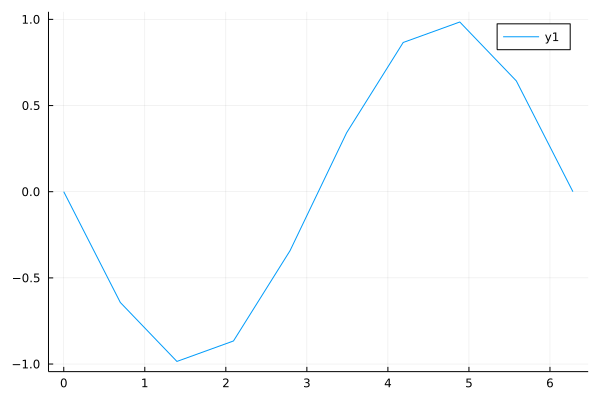

In [35]:
xx = LinRange(0, 2π, 10)
plot(xx, dercos.(xx))

### Test power output

In [9]:
print("P = " * string(powerout(6, ϕinput, scattpos, alphas, ω, J; normalized=false)[1]))
print("\nP = " * string(powerout(6, ϕinput, scattpos, alphas, ω, J; normalized=true)[1]))

P = 1.158348522057697e37
P = 1.2681589355246427e33

In [10]:
print("P = " * string(powerout(6, ϕinput, scattpos, alphas, ω, J)[1]))
print("\nP = " * string(poweroutexplicit(6, ϕinput, scattpos, alphas, ω, J)[1]))
print("\nP = " * string(evalsumm(2, ϕinput, scattpos, alphas, ω, J)))

P = 1.158348522057697e37
P = 1.4958073693805817e37


P = 2.9514790517935283e20

In [5]:
println(intmatrix(scattpos, alphas, ω, J));
println(alphas);
println(incfield(ϕinput, scattpos, alphas, ω, J));

ComplexF64[0.0 - 0.012665147955292222im -0.012665147955292222 + 3.1020666009924618e-18im; -0.012665147955292222 + 3.1020666009924618e-18im -0.0 + 0.012665147955292222im]
ComplexF64

[0.0 + 78.95683520871486im, -0.0 - 78.95683520871486im]
ComplexF64[1.0216084176397266e17 + 4.68826889307241e15im, 4.688268893072426e15 - 1.0216084176397272e17im]


### Test 1/4pi Green's function

In [21]:
powerout(2, ϕinput, scattpos, alphas, ω, J)[1] * 4π

1.0000000000000653

In [22]:
poweroutexplicit(2, ϕinput, scattpos, alphas, ω, J)[1] * 4π

1.000000000000065

### Test gradient

In [3]:
xx = LinRange(0, 10, 20)
f(x) = sin(x[1]) + cos(x[2])
g(x) = ForwardDiff.gradient(f, x)

g (generic function with 1 method)

In [13]:
yy = zeros(20)
yy2 = zeros(20)

for i in 1:20
    yy[i] = f([0, xx[i]])
    yy2[i] = g([0, xx[i]])[2]
end

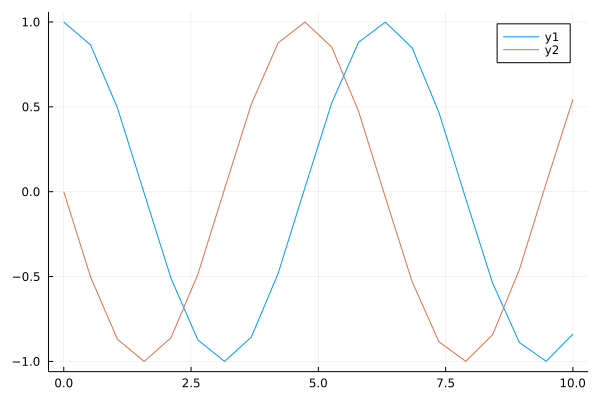

In [14]:
plot(xx, yy)
plot!(xx, yy2)